In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

sns.set_style("whitegrid")

In [12]:
PRIORIDAD_PATH = '../data/processed/topicos_priorizados.csv'
MODEL_PATH = '../models/lda_model.pkl'
VECTORIZER_PATH = '../models/tfidf_vectorizer.pkl'
PARAMS_PATH = '../params.yaml'

# dataframe de prioridad
df_prioridad = pd.read_csv(PRIORIDAD_PATH)

# modelo LDA y vectorizador
with open(MODEL_PATH, 'rb') as f:
    lda = pickle.load(f)
with open(VECTORIZER_PATH, 'rb') as f:
    vectorizer = pickle.load(f)
    
# tópicos (n_topics)
with open(PARAMS_PATH, 'r') as f:
    n_topics = yaml.safe_load(f)['nlp']['n_topics']

print(f"Datos cargados. Tópicos totales analizados: {n_topics}")

Datos cargados. Tópicos totales analizados: 20


c:\Users\Berner\anaconda3\envs\p312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.5.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Berner\anaconda3\envs\p312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Berner\anaconda3\envs\p312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when u

In [13]:
def get_topic_names(model, vectorizer, top_n=5):
    """Extrae las palabras clave para nombrar cada tópico."""
    feature_names = vectorizer.get_feature_names_out()
    topic_names = {}
    
    for topic_idx, topic in enumerate(model.components_):
        # índices de palabras más importantes
        top_features_ind = topic.argsort()[:-top_n - 1:-1]
        
        # palabras clave
        top_features = [feature_names[i] for i in top_features_ind]
        
        # crear label
        topic_names[topic_idx] = " / ".join(top_features)
        
    return topic_names

# mapear los nombres de los tópicos
topic_names_map = get_topic_names(lda, vectorizer, top_n=5)
#topic_names_map
df_prioridad['nombre_topico'] = df_prioridad['topico_principal'].map(topic_names_map)

print("\n--- Tópicos Priorizados por Score ---")
print(df_prioridad[['topico_principal', 'nombre_topico', 'satisfaccion_media', 'volumen', 'prioridad_score']].head(5))


--- Tópicos Priorizados por Score ---
   topico_principal                                      nombre_topico  \
0                10           moto / buenas / eficiente / motos / solo   
1                11  moto / servicio amabilidad / rapido / brindaro...   
2                 2  rapidez / tiempo / repuestos / espera / dispon...   
3                 8  exelente / exelente servicio / servicio / hond...   
4                12     amable / personal / atendido / atención / bien   

   satisfaccion_media  volumen  prioridad_score  
0            7.408964     1428            370.0  
1            7.710568     1268            290.3  
2            8.034419     1075            211.3  
3            8.262084      931            161.8  
4            8.854406     1044            119.6  


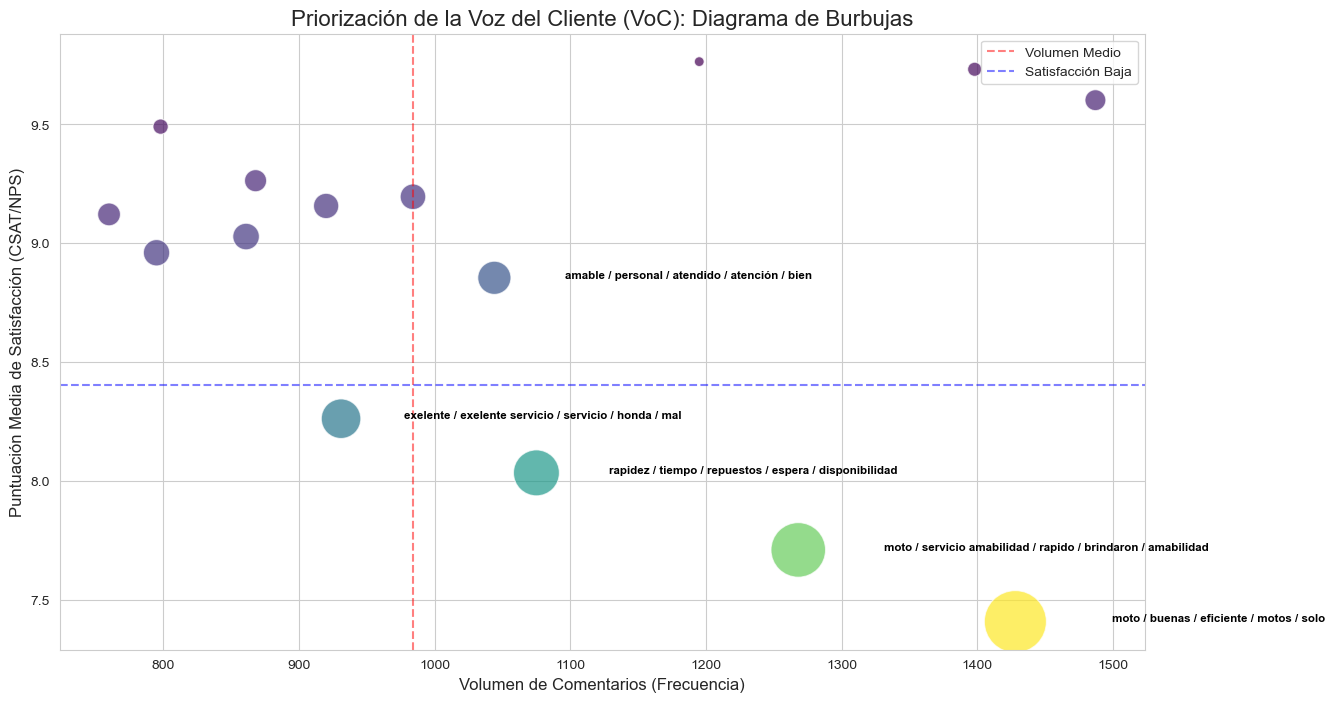

In [ ]:
scale_factor = 400
sizes = df_prioridad['prioridad_score'] * scale_factor

plt.figure(figsize=(14, 8))

# x: cantidad (impacto)
# y: satisfacción (qué tan bien lo estamos haciendo)
scatter = sns.scatterplot(
    data=df_prioridad,
    x='volumen',
    y='satisfaccion_media',
    size=sizes,          # score de prioridad
    sizes=(50, 2000),    
    hue='prioridad_score', # Color basado en el score (opcional)
    palette="viridis",
    legend=False,
    alpha=0.7
)

# Zona de "Acción Inmediata" (Temas Calientes)
max_sat = df_prioridad['satisfaccion_media'].max()
umbral_volumen = df_prioridad['volumen'].median()
umbral_satisfaccion = df_prioridad['satisfaccion_media'].mean() - 0.5 # Media - un margen

# Resaltar la zona crítica (Volumen Alto, Satisfacción Baja)
plt.axvline(x=umbral_volumen, color='r', linestyle='--', alpha=0.5, label='Volumen Medio')
plt.axhline(y=umbral_satisfaccion, color='b', linestyle='--', alpha=0.5, label='Satisfacción Baja')

# Etiquetar los tópicos más importantes (los de mayor prioridad)
for line in range(0, df_prioridad.shape[0]):
    if df_prioridad['prioridad_score'].iloc[line] >= df_prioridad['prioridad_score'].max() * 0.3:
        plt.text(
            df_prioridad['volumen'].iloc[line] * 1.05, 
            df_prioridad['satisfaccion_media'].iloc[line], 
            df_prioridad['nombre_topico'].iloc[line], 
            horizontalalignment='left', 
            size='small', 
            color='black', 
            weight='semibold'
        )

plt.title('Priorización de la Voz del Cliente (VoC): Diagrama de Burbujas', fontsize=16)
plt.xlabel('Volumen de Comentarios (Frecuencia)', fontsize=12)
plt.ylabel('Puntuación Media de Satisfacción (CSAT/NPS)', fontsize=12)
plt.legend(loc='upper right')
plt.show()